# Q1.a

In [5]:

import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import pyomo.environ as pe
from tqdm.notebook import tqdm

In [6]:
train = pd.read_csv('train.csv').iloc[:,1:]
test = pd.read_csv('test.csv').iloc[:,1:]

In [7]:
y_train = np.array(train['Y'])
x_train = np.array(train.iloc[:,:2])
y_test = np.array(test['Y'])
x_test = np.array(test.iloc[:,:2])

In [57]:
np.random.seed(0)
forest = RandomForestRegressor(
    n_estimators=500,max_depth=5
   )
forest.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=500)

In [58]:
y_pred = forest.predict(x_test)

In [36]:
def cost_func(z, y, c=0.5, p=1):
    return c*z - p*np.minimum(z, y)

In [60]:
T = 500
c, p = 0.5, 1
z_PTO = np.zeros(T)
solver = pe.SolverFactory('gurobi')
for t in range(T):
    model_PTO = pe.ConcreteModel()
    model_PTO.z = pe.Var(domain=pe.NonNegativeReals)
    model_PTO.s = pe.Var(domain=pe.Reals)
    model_PTO.cost = pe.Objective(expr=c*model_PTO.z-p*model_PTO.s)
    model_PTO.constraint1 = pe.Constraint(expr=model_PTO.s<=model_PTO.z)
    model_PTO.constraint2 = pe.Constraint(expr=model_PTO.s<= y_pred[t])
    solver.solve(model_PTO)
    z_PTO[t] = model_PTO.z()

In [68]:
perf_PTO = cost_func(z_PTO, y_test)
print("Predict then optimize approach")
print("Expected cost: {0:0.4f}".format(perf_PTO.mean()))

Predict then optimize approach
Expected cost: -7.1625


So the Expected cost is lower than the linear model. 

# Q1.b

In [69]:
leaves = forest.apply(x_train)

leaves

array([[42, 42, 24, ..., 40, 40, 24],
       [60, 60, 55, ..., 58, 56, 53],
       [38, 35, 20, ..., 33, 34, 20],
       ...,
       [42, 42, 23, ..., 40, 38, 23],
       [42, 42, 23, ..., 40, 38, 23],
       [34, 25, 15, ..., 32, 25, 15]], dtype=int64)

In [70]:
m=len(leaves[1])
m

500

In [71]:
n=len(leaves)
n

1000

In [72]:
# Create an array that each element contains the result of each tree.
pred_each = []
for i in range(m):
    
    temp = []
    for j in range(n):
        temp.append(leaves[j][i])
    pred_each.append(temp)
pred_each_array = np.array(pred_each)     

In [73]:
z_rf_int = np.zeros(T)

for t in tqdm(range(T)):    
    w = np.zeros(n) 
    model_rf_int = pe.ConcreteModel() 
    model_rf_int.z = pe.Var(domain=pe.NonNegativeReals)
    model_rf_int.s = pe.Var(range(n), domain=pe.Reals)
       
    for j in range(m):     
        leaves1 = pred_each_array[j]
        leaf = forest.apply([x_test[t, :]])[0][j]
        tot = sum(leaf == leaves1) 
        for i in range(n):
            w[i] = w[i]+((leaf == leaves1[i]) / tot)
        
    for e in range(n):
        w[e] = w[e]/m
    
    model_rf_int.cost = pe.Objective(expr=sum(w[i]*(c*model_rf_int.z-p*model_rf_int.s[i]) for i in range(n)))
    model_rf_int.constraint1 = pe.Constraint(range(n), rule=
                                          lambda mod, i: mod.s[i] <= mod.z)
    model_rf_int.constraint2 = pe.Constraint(range(n), rule=
                                          lambda mod, i: mod.s[i] <= y_train[i])
    solver.solve(model_rf_int)
    z_rf_int[t] = model_rf_int.z()

  0%|          | 0/500 [00:00<?, ?it/s]

In [77]:
perf_tree = cost_func(z_rf_int, y_test)
print("Integrated approach (trees)")
print("Expected cost: {0:0.4f}".format(perf_tree.mean()))

Integrated approach (trees)
Expected cost: -7.1215


So the Expected cost is higher than the linear model. 

# Q1.c

In [10]:
from sklearn.kernel_ridge import KernelRidge
from sklearn import datasets
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import uniform
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern

In [27]:
import math

'''Class for Gaussian Kernel Regression'''
class GKR:
    
    def __init__(self, x, y, b):
        self.x = np.array(x)
        self.y = np.array(y)
        self.b = b
    
    '''Implement the Gaussian Kernel'''
    def gaussian_kernel(self, z):
        return (1/np.sqrt(2*np.pi))*np.exp(-0.5*z**2)
    
    '''Calculate weights and return prediction'''
    def predict(self, X):
        kernels = np.array([self.gaussian_kernel((np.linalg.norm(xi-X))/self.b) for xi in self.x])
        weights = np.array([len(self.x) * (kernel/np.sum(kernels)) for kernel in kernels])
        return np.dot(weights.T, self.y)/len(self.x)
    def weights(self, X):
        kernels = np.array([self.gaussian_kernel((np.linalg.norm(xi-X))/self.b) for xi in self.x])
        weights = np.array([len(self.x) * (kernel/np.sum(kernels)) for kernel in kernels])
        return weights

In [46]:
cost=[]
for i in range(1,11):
    model_gkr=GKR(x_train,y_train,i)
    c=0.5
    p=1
    T = 500
    n = 1000
    z_gpr_int = np.zeros(T)
    solver = pe.SolverFactory('gurobi')
    for t in tqdm(range(T)) :
        model_gkr_int = pe.ConcreteModel()
        model_gkr_int.z = pe.Var(domain=pe.NonNegativeReals)
        model_gkr_int.s = pe.Var(range(n), domain=pe.Reals)
        w = model_gkr.weights(x_test[t])/1000
        model_gkr_int.cost = pe.Objective(expr=sum(w[i]*(c*model_gkr_int.z-p*model_gkr_int.s[i]) for i in range(n)))
        model_gkr_int.constraintl =  pe.Constraint(range(n), rule=
                                              lambda mod, i: mod.s[i] <= mod.z)
        model_gkr_int.constraint2 = pe.Constraint(range(n), rule=
                                              lambda mod, i: mod.s[i] <= y_train[i])
        solver.solve(model_gkr_int)
        z_gpr_int[t] = model_gkr_int.z()
    perf_gpr= cost_func(z_gpr_int, y_test)
    cost.append([i,perf_gpr.mean()])

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [47]:
cost

[[1, -7.157078572805521],
 [2, -6.931984016939728],
 [3, -6.432739409484123],
 [4, -5.741533367604343],
 [5, -5.157305824220928],
 [6, -4.86084340914442],
 [7, -4.665403151255902],
 [8, -4.558430996551987],
 [9, -4.493427607704487],
 [10, -4.455665311979002]]

So we choose 1 as the width, and the cost will be -7.157078572805521.

# Q2.a

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def toy_2d_f(eta, iters = 10):
    x, y = 0.0, 2.0
    updates = [[x,y]]
    for i in range(iters):
        x-= eta * (2 * x-10+y)
        y -= eta * (4*y+12+x)
        updates.append([x,y])
    print("x is %.4f, y is %.4f" % (x,y))
    return np.array(updates)


In [3]:
def contour_plot(x, y, z, gs):
    fig, ax = plt.subplots(figsize = (8,6))
    cp = ax.contour(x, y, z, levels = [(i/8)**3 for i in range(-10,70)])
    ax.clabel(cp, inline = 0.2, fontsize = 10)
    fig.colorbar(cp)
    ax.set_xlabel('$x$', fontsize = 12)
    ax.set_ylabel('$y$', fontsize = 12)
    ax.set_xlim([-10, 10]), ax.set_ylim([-10, 10])
    for i in range(len(gs)-1):
        plt.annotate(
            '', xy = gs[i+1,:], xytext = gs[i,:],
            arrowprops = {'arrowstyle': '->', 'color': 'r', 'lw': 1},
            va = 'center', ha = 'center')

x is 3.7221, y is -3.0817


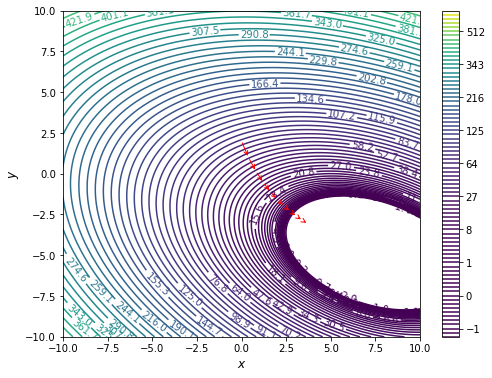

In [4]:
x = np.linspace(-10.0, 10.0, 1000)
y = np.linspace(-10.0, 10.0, 1000)
X, Y = np.meshgrid(x,y)
Z = np.square(X-5) + 2*np.square(Y+3)+X*Y
contour_plot(X, Y, Z, toy_2d_f(0.05, iters = 10))

In [5]:
def toy_2d_f(eta, iters = 10):
    x, y = 0.0, 2.0
    updates = [[x,y]]
    for i in range(iters):
        x-= eta * (2 * x-10+y)
        y -= eta * (4*y+12+x)
        updates.append([x,y])
    print("x is %.4f, y is %.4f" % (x,y))
    return np.array(updates)

In [6]:
import sympy as sym
from sympy.abc import x,y
expr_g = (1-(y-3))**2 + 10*((x+4)-(y-3)**2)**2

In [7]:
diff_x_g =sym.diff(expr_g,x)
diff_y_g=sym.diff(expr_g,y)

In [12]:
diff_y_g

2*y + 10*(12 - 4*y)*(x - (y - 3)**2 + 4) - 8

In [21]:
diff_x_g

20*x - 20*(y - 3)**2 + 80

In [22]:
def toy_2d_g(eta, iters = 100):
    x, y = 0.0, 2.0
    updates = [[x,y]]
    for i in range(iters):
        x-= eta * (20*x-20*(y-3)**2+80)
        y -= eta * (2*y+10*(12-4*y)*(x-(y-3)**2+4)-8)
        updates.append([x,y])
    print("x is %.4f, y is %.4f" % (x,y))
    return np.array(updates)

In [43]:
def contour_plot(x, y, z, gs):
    fig, ax = plt.subplots(figsize = (8,6))
    cp = ax.contour(x, y, z, levels = [(i/8)**3 for i in range(-10,200)])
    ax.clabel(cp, inline = 0.2, fontsize = 10)
    fig.colorbar(cp)
    ax.set_xlabel('$x$', fontsize = 12)
    ax.set_ylabel('$y$', fontsize = 12)
    ax.set_xlim([-10, 10]), ax.set_ylim([-10, 10])
    for i in range(len(gs)-1):
        plt.annotate(
            '', xy = gs[i+1,:], xytext = gs[i,:],
            arrowprops = {'arrowstyle': '->', 'color': 'r', 'lw': 1},
            va = 'center', ha = 'center')

x is -0.5697, y is 1.1680


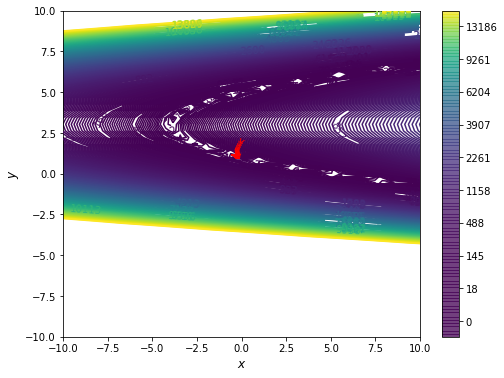

In [44]:
x = np.linspace(-20.0, 20.0, 100)
y = np.linspace(-20.0, 20.0, 100)
X, Y = np.meshgrid(x,y)
Z = (1-(Y-3))**2 + 10*((X+4)-(Y-3)**2)**2
contour_plot(X, Y, Z, toy_2d_g(0.0015, iters = 100))

# Q2.b

In [55]:
import math
import numpy as np
import matplotlib.pyplot as plt
def piecewise(ctr = 1, d = 2, binwidth = 10):
    divisor = 1
    ctr += 1
    if ctr % binwidth==0:
        divisor /= d
    return divisor**(ctr//binwidth)
def exponential(ctr = 1, λ = 0.1):
    ctr += 1
    return math.exp(-λ * ctr)
def polynomial(ctr = 1, alpha = 0.5, beta = 0.1):
    ctr += 1
    return (1 + beta * ctr)**( alpha)

In [113]:
def f(X,Y): 
    return np.square(X-5) + 2*np.square(Y+3)+X*Y 
def gradf(x,y): 
    return 2 * x-10+y, 4*y+12+x
np.random.seed(0)
def toy_sgd(eta, lr, iters):
    np.random.seed(0)
    x,y = 0, 2
    updates = [[x, y]]
    for i in range(iters):
        g1, g2 = gradf(x, y)
        eta_t = eta * lr()
        x -= eta_t * (g1 + np.random.normal(0.1))
        y -= eta_t * (g2 + np.random.normal(0.1))
        updates.append([x, y])

    return np.array(updates)

In [119]:
fvalue=[]
for i in np.arange(0,1,0.05):
    fvalue.append([i,f(toy_sgd(i, lr = polynomial, iters = 10)[10][0],toy_sgd(i, lr = polynomial, iters = 10)[10][1])])
fvalue    #find the best eta from 0 to 1

[[0.0, 75.0],
 [0.05, -9.954122697555379],
 [0.1, -20.748626002449093],
 [0.15000000000000002, -22.641132767715753],
 [0.2, -22.972164405941236],
 [0.25, -23.0044272431084],
 [0.30000000000000004, -22.977585152570228],
 [0.35000000000000003, -22.95570363822811],
 [0.4, -19.26145125023229],
 [0.45, 448.70983472470425],
 [0.5, 23608.86013388038],
 [0.55, 605782.9606683422],
 [0.6000000000000001, 9732978.303634584],
 [0.65, 110682314.9084154],
 [0.7000000000000001, 963480243.0971795],
 [0.75, 6775002230.69268],
 [0.8, 40005433424.69337],
 [0.8500000000000001, 204197250125.56488],
 [0.9, 921220179571.7424],
 [0.9500000000000001, 3738091807954.3384]]

It is obvious that when eta=0.25, fvalue is smallest. So we choose 0.25 as the eta, the f value is -23.0044272431084.

In [128]:
print("x is %.4f, y is %.4f" % (toy_sgd(0.25, lr = polynomial, iters = 10)[10][0],toy_sgd(0.25, lr = polynomial, iters = 10)[10][1]))

x is 7.0099, y is -4.4996


In [122]:
def toy_traces_2d(f, updates):
    x = np.arange(-10, 10.0, 0.1)
    y = np.arange(-10.0, 10.0, 0.1)
    X,Y = np.meshgrid(x,y)
    fig = plt.figure(figsize = (4,3), dpi = 120)
    plt.contour(X,Y, f(X,Y), colors = ['#1f77b4'])
    plt.plot(*zip(*updates), '-o', color = '#ff7f0e', alpha = 0.8, markersize = 5)

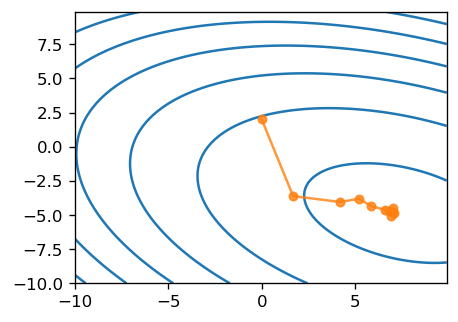

In [123]:
toy_traces_2d(f, toy_sgd(0.25, lr = polynomial, iters = 10))

In [131]:
def g(X,Y): 
    return (1-(Y-3))**2 + 10*((X+4)-(Y-3)**2)**2 
def gradg(x,y): 
    return 20*x-20*(y-3)**2+80, 2*y+10*(12-4*y)*(x-(y-3)**2+4)-8
np.random.seed(0)
def toy_sgdg(eta, lr, iters):
    np.random.seed(0)
    x,y = 0, 2
    updates = [[x, y]]
    for i in range(iters):
        g1, g2 = gradg(x, y)
        eta_t = eta * lr()
        x -= eta_t * (g1 + np.random.normal(0.1))
        y -= eta_t * (g2 + np.random.normal(0.1))
        updates.append([x, y])

    return np.array(updates)

In [137]:
gvalue=[]
for i in np.arange(0,0.02,0.0005):
    gvalue.append([i,g(toy_sgdg(i, lr = polynomial, iters = 100)[100][0],toy_sgdg(i, lr = polynomial, iters = 100)[100][1])])
gvalue    #find the best eta from 0 to 1

[[0.0, 94.0],
 [0.0005, 8.324305079993591],
 [0.001, 8.192533097140792],
 [0.0015, 8.059596095055808],
 [0.002, 7.9252011873200665],
 [0.0025, 7.789149560828512],
 [0.003, 7.651208126817749],
 [0.0035, 7.511167055185625],
 [0.004, 7.368696999602073],
 [0.0045000000000000005, 7.2229297811197855],
 [0.005, 7.0725941583716505],
 [0.0055, 6.916516452121676],
 [0.006, 6.749448640024022],
 [0.006500000000000001, 6.526431793912189],
 [0.007, 6.175886236085824],
 [0.0075, 5.552062686022148],
 [0.008, 5.067573524542011],
 [0.0085, 4.762893969515059],
 [0.009000000000000001, 4.167763315847583],
 [0.0095, 3.8051768989849464],
 [0.01, 3.126459661652445],
 [0.0105, 0.02100985048234214],
 [0.011, 0.04441285350251542],
 [0.0115, nan],
 [0.012, 0.019423785444402444],
 [0.0125, nan],
 [0.013000000000000001, nan],
 [0.0135, nan],
 [0.014, nan],
 [0.0145, nan],
 [0.015, nan],
 [0.0155, nan],
 [0.016, nan],
 [0.0165, nan],
 [0.017, nan],
 [0.0175, nan],
 [0.018000000000000002, nan],
 [0.0185, nan],
 [0.01

It is obvious that when eta=0.012, gvalue is smallest. So we choose 0.012 as the eta, the g value is 0.019423785444402444.

In [140]:
print("x is %.4f, y is %.4f" % (toy_sgdg(0.012, lr = polynomial, iters = 100)[100][0],toy_sgdg(0.012, lr = polynomial, iters = 100)[100][1]))

x is -2.7068, y is 4.1303


In [158]:
def toy_traces_2dg(g, updates):
    x = np.arange(-5, 3.0, 0.01)
    y = np.arange(-1.0, 6.0, 0.01)
    X,Y = np.meshgrid(x,y)
    fig = plt.figure(figsize = (4,3), dpi = 120)
    plt.contour(X,Y, g(X,Y), colors = ['#1f77b4'])
    plt.plot(*zip(*updates), '-o', color = '#ff7f0e', alpha = 0.8, markersize = 5)

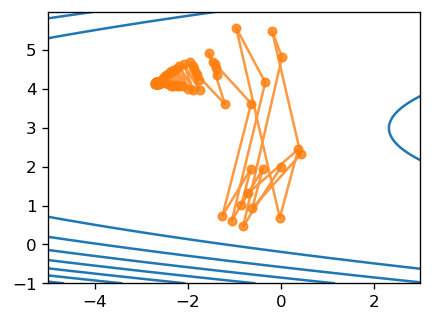

In [159]:
toy_traces_2dg(g, toy_sgdg(0.012, lr = polynomial, iters = 100))